**Importing necessary libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Reading the dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Predicting Job Type by Job Description.csv', encoding='latin-1')
df.head(1)

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"


**Checking for missing values**

In [ ]:
df.isnull().sum()

job_no             0
job_description    0
job_type           0
category           0
dtype: int64

**Checking the shape of dataset**

In [ ]:
df.shape

(17657, 4)

**Removing duplicates if there are any**

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(17657, 4)

In [ ]:
df.head(1)

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"


**Selecting relevant columns**

In [ ]:
df = df.iloc[:,1:3]
df.head(1)

,job_description,job_type
0,Zest Scientific is searching for an accomplis...,Permanent


**Checking class distribution**

In [ ]:
df['job_type'].value_counts()

Permanent             15777
Contract/Interim       1414
Contract/Temp           305
Temporary/Seasonal      113
Any                      25
Part-Time                23
Name: job_type, dtype: int64

**The dataset is highly imbalanced.**

**Assigning numerical values to different output classes**

In [ ]:
df.replace ({"job_type": {'Permanent':0, 'Contract/Interim':1, "Contract/Temp": 2, "Temporary/Seasonal": 3,
                          "Any": 4, "Part-Time": 5}}, inplace = True)

In [ ]:
df['job_type'].value_counts()

0    15777
1     1414
2      305
3      113
4       25
5       23
Name: job_type, dtype: int64

**Separating dependent and indpendent features**

In [ ]:
x = df.drop ('job_type', axis =1)
y = df['job_type']

In [ ]:
messages = x.copy()

In [ ]:
lem = WordNetLemmatizer()

In [ ]:
# Data Preprocessing (Lemmatization)
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['job_description'][i])
    review = review.lower()
    review = review.split()
    review = [lem.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
tokenized_corpus = [sentence.split() for sentence in corpus]

all_words = [word for sentence in tokenized_corpus for word in sentence]

# finding for the number of unique words in the dataframe
vocabulary_size = len(set(all_words))

# finding for number of number of words in the sentence with the maximum length
max_sentence_length = max(len(sentence) for sentence in tokenized_corpus)

print("Vocabulary Size:", vocabulary_size)
print("Maximum Sentence Length:", max_sentence_length)

Vocabulary Size: 41341
Maximum Sentence Length: 964


In [ ]:
# One hot encoding of the data
onehot_repr= [one_hot (words, vocabulary_size) for words in corpus]

In [ ]:
# Applying padding to ensure equal length of data
embedded_docs = pad_sequences(onehot_repr, padding='post', maxlen = max_sentence_length)
print(embedded_docs)

[[22238 11041 18936 ...     0     0     0]
 [33489 40206 15485 ...     0     0     0]
 [11615 23470  2173 ...     0     0     0]
 ...
 [ 8077 23695 24738 ...     0     0     0]
 [11615 23470 15709 ...     0     0     0]
 [ 8268 31604 36782 ...     0     0     0]]


**Converting the data type of dependent and indpendent features to numpy array**

In [ ]:
x_final = np.array(embedded_docs)
y_final = np.array(y)

In [ ]:
x_final.shape, y_final.shape

((17657, 964), (17657,))

**Converting the dependent and indpendent features back to pandas dataframe**

In [ ]:
x_final_df = pd.DataFrame (x_final)
y_final_df = pd.DataFrame (y_final, columns = ['y'])

In [ ]:
x_final_df.shape

(17657, 964)

In [ ]:
x_final_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,954,955,956,957,958,959,960,961,962,963
0,22238,11041,18936,19365,11041,10725,34667,5129,18845,9285,...,0,0,0,0,0,0,0,0,0,0


**Concatenating the dependent and indpendent features**

In [ ]:
df_final = pd.concat ([x_final_df, y_final_df], axis = 1)
df_final.head(3)

,0,1,2,3,4,5,6,7,8,9,...,955,956,957,958,959,960,961,962,963,y
0,22238,11041,18936,19365,11041,10725,34667,5129,18845,9285,...,0,0,0,0,0,0,0,0,0,0
1,33489,40206,15485,15709,19789,36782,38417,21353,17874,20769,...,0,0,0,0,0,0,0,0,0,0
2,11615,23470,2173,29507,15398,30241,33592,33451,24222,4148,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Splitting the dataset in to training, validation and test sets

y_for_df_stratification = df_final['y']
train_old, test = train_test_split (df_final, test_size=0.2, random_state=10, stratify = y_for_df_stratification, shuffle = True)

y_to_stratify_train = train_old['y']
train, val = train_test_split (train_old, test_size=0.2, random_state=10, stratify = y_to_stratify_train, shuffle = True)

In [ ]:
df['job_type'].value_counts()

0    15777
1     1414
2      305
3      113
4       25
5       23
Name: job_type, dtype: int64

In [ ]:
class_0 = 15777
class_1 = 1414
class_2 = 305
class_3 = 113
class_4 = 25
class_5 = 23

print (class_0, class_1, class_2, class_3, class_4, class_5)

15777 1414 305 113 25 23


In [ ]:
x_train = train.drop('y', axis =1)
y_train = train['y']

x_val = val.drop('y', axis =1)
y_val = val['y']

x_test = test.drop('y', axis =1)
y_test = test['y']

**Converting the data types of dependent and indpendent features back to numpy array**

In [ ]:
x_train = np.array (x_train)
x_val = np.array (x_val)
x_test = np.array (x_test)
y_train = np.array (y_train)
y_val = np.array (y_val)
y_test = np.array (y_test)

**Introducing early stopping to avoid overfitting**

In [ ]:
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
print (class_0, class_1, class_2, class_3, class_4, class_5)

15777 1414 305 113 25 23


In [ ]:
15777/23

685.9565217391304

In [ ]:
# finding and assigning weights to different classes in order to account for the imbalanced classes

weights_assigned = {0 : 1, 1 : 11.157708628005658, 2 : 51.72786885245902,
                    3 : 139.61946902654867, 4 : 631.08, 5 : 685.9565217391304}

In [ ]:
## Creating model
embedding_vector_features = 40
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_vector_features, input_length = max_sentence_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.3))
model.add(Dense(units = 6, activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 964, 40)           1653640   
                                                                 
 dropout (Dropout)           (None, 964, 40)           0         
                                                                 
 bidirectional (Bidirection  (None, 400)               385600    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 2041646 (7.79 MB)
Trainable params: 2041646 (7.79 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
# Model Training
model_history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=1000, batch_size=100, callbacks=early_stopping,
                          class_weight = weights_assigned)

Epoch 1/1000
113/113 [==============================] - 50s 370ms/step - loss: 10.7477 - accuracy: 0.3854 - val_loss: 1.4135 - val_accuracy: 0.8598
Epoch 2/1000
113/113 [==============================] - 40s 352ms/step - loss: 8.9045 - accuracy: 0.4497 - val_loss: 0.8032 - val_accuracy: 0.9087
Epoch 3/1000
113/113 [==============================] - 37s 329ms/step - loss: 5.3886 - accuracy: 0.7346 - val_loss: 0.7442 - val_accuracy: 0.7437
Epoch 4/1000
113/113 [==============================] - 36s 322ms/step - loss: 3.1548 - accuracy: 0.8498 - val_loss: 0.7732 - val_accuracy: 0.7359
Epoch 5/1000
113/113 [==============================] - 31s 277ms/step - loss: 1.9258 - accuracy: 0.8799 - val_loss: 0.2802 - val_accuracy: 0.9381
Epoch 6/1000
113/113 [==============================] - 31s 275ms/step - loss: 1.1933 - accuracy: 0.9160 - val_loss: 0.2701 - val_accuracy: 0.9076
Epoch 7/1000
113/113 [==============================] - 35s 312ms/step - loss: 0.9795 - accuracy: 0.9458 - val_loss: 

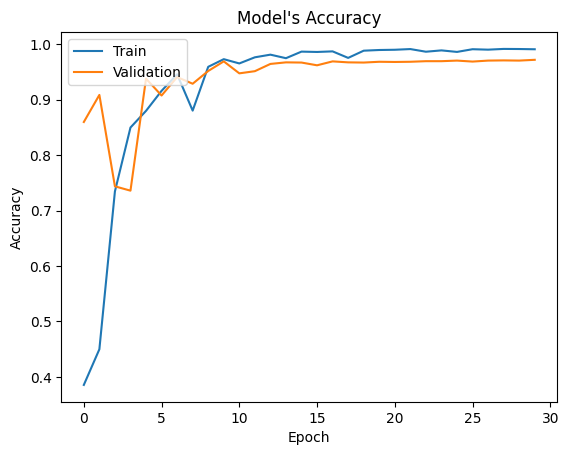

In [ ]:
# Plotting Model's Accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title("Model's Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

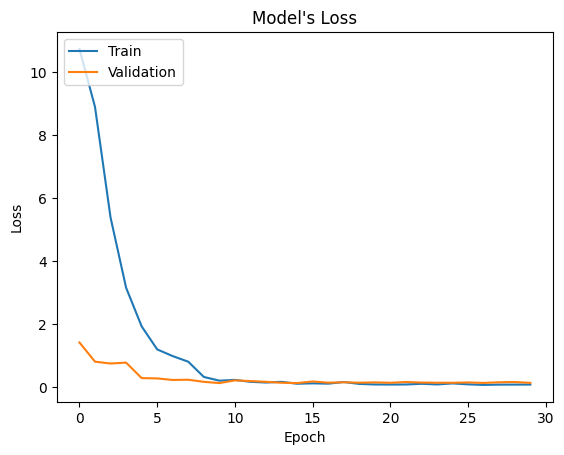

In [ ]:
# Plotting Model's Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title("Model's Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Making prediction on training and test sets

y_pred_train = model.predict(x_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

111/111 [==============================] - 3s 31ms/step


In [ ]:
# Calculating and printing accuracy on training and test sets

training_accuracy = accuracy_score (y_pred_train, y_train)
test_accuracy = accuracy_score (y_pred_test, y_test)

print ('training accuracy:', training_accuracy)
print ('test accuracy:', test_accuracy)

training accuracy: 0.991858407079646
test accuracy: 0.9818799546998868


In [ ]:
# Constructing and printing the confusion matrices on training and test sets

cm_train = confusion_matrix (y_train, y_pred_train)
cm_test = confusion_matrix (y_test, y_pred_test)

print ('CM Train:\n', cm_train)
print ('CM Test:\n', cm_test)

CM Train:
 [[10007    24     1    62     0     3]
 [    1   904     0     0     0     0]
 [    0     0   194     1     0     0]
 [    0     0     0    72     0     0]
 [    0     0     0     0    16     0]
 [    0     0     0     0     0    15]]
CM Test:
 [[3130   14    3    9    0    0]
 [  28  254    0    1    0    0]
 [   7    0   54    0    0    0]
 [   2    0    0   21    0    0]
 [   0    0    0    0    5    0]
 [   0    0    0    0    0    4]]


In [ ]:
# Calculating the number of correct predictions, number of incorrect predictions, & precision, recall &
# f1 score on the training set

print ("Correct predictions on training data:", sum (y_train == y_pred_train))
print ("Incorrect predictions on training data:", sum (y_train != y_pred_train))
print ("F1 Score on training data:", f1_score(y_train, y_pred_train, average='macro'))
print ('Precision on training data: %.3f' % precision_score(y_train, y_pred_train, average='macro'))
print ('Recall on training data: %.3f' % recall_score(y_train, y_pred_train, average='macro'))

Correct predictions on training data: 11208
Incorrect predictions on training data: 92
F1 Score on training data: 0.9302416328658759
Precision on training data: 0.889
Recall on training data: 0.997


In [ ]:
# Calculating the number of correct predictions, number of incorrect predictions, & precision, recall &
# f1 score on the test set

print ("Correct predictions on test data:", sum (y_test == y_pred_test))
print ("Incorrect predictions on test data:", sum (y_test != y_pred_test))
print ("F1 Score on test data:", f1_score(y_test, y_pred_test, average='macro'))
print ('Precision on test data: %.3f' % precision_score(y_test, y_pred_test, average='macro'))
print ('Recall on test data: %.3f' % recall_score(y_test, y_pred_test, average='macro'))

Correct predictions on test data: 3468
Incorrect predictions on test data: 64
F1 Score on test data: 0.9341714104665964
Precision on test data: 0.927
Recall on test data: 0.948


In [ ]:
# Printing the classification reports on training and test sets

print ("Classification report of training data:\n", classification_report (y_train, y_pred_train, digits = 4))
print ("Classification report of test data:\n", classification_report (y_test, y_pred_test, digits = 4))

Classification report of training data:
               precision    recall  f1-score   support

           0     0.9999    0.9911    0.9955     10097
           1     0.9741    0.9989    0.9864       905
           2     0.9949    0.9949    0.9949       195
           3     0.5333    1.0000    0.6957        72
           4     1.0000    1.0000    1.0000        16
           5     0.8333    1.0000    0.9091        15

    accuracy                         0.9919     11300
   macro avg     0.8893    0.9975    0.9302     11300
weighted avg     0.9946    0.9919    0.9927     11300

Classification report of test data:
               precision    recall  f1-score   support

           0     0.9883    0.9918    0.9900      3156
           1     0.9478    0.8975    0.9220       283
           2     0.9474    0.8852    0.9153        61
           3     0.6774    0.9130    0.7778        23
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         4


In [ ]:
# making predictions from the trained model based on user input

prediction = input("Enter the text you want to predict: ")

corpus_prediction = []

review_prediction = re.sub('[^a-zA-Z]', ' ', prediction)
review_prediction = review_prediction.lower()
review_prediction = review_prediction.split()
review_prediction = [lem.lemmatize(word) for word in review_prediction if not word in stopwords.words('english')]
review_prediction = ' '.join(review_prediction)
corpus_prediction.append(review_prediction)

onehot_repr_prediction = [one_hot(words, vocabulary_size) for words in corpus_prediction]

embedded_docs_prediction = pad_sequences(onehot_repr_prediction, padding='post', maxlen=max_sentence_length)

x_prediction = np.array(embedded_docs_prediction)

y_pred_prediction = model.predict(x_prediction)

y_pred_prediction = np.argmax(y_pred_prediction, axis=1)

if y_pred_prediction == 0:
  print('The job type is permanent.')
elif y_pred_prediction == 1:
  print('The job type is interim.')
elif y_pred_prediction == 2:
  print('The job type is temporary.')
elif y_pred_prediction == 3:
  print('The job type is seasonal.')
elif y_pred_prediction == 4:
  print('The job type is any.')
elif y_pred_prediction == 5:
  print('The job type is part-time.')

Enter the text you want to predict: We are currently recruiting for a market leading Pharmacy chain with an exciting new opportunity working as a Pharmacist Manager working in Abingdon. Our client are a forward thinking company with a heavy emphasis on training and support, as well as customer service.   Essential Requirements:    You will be a highly experienced Pharmacist with current valid GPHC registration and MUR accreditation.   You will have ProScript experience.   Ability to build good relationships with both customers and staff.   Possess exceptional leadership qualities.   Ability to lead and motivate a team.   Outstanding attention to detail.   Role Responsibilities:   Managing a team, you will inspire and develop colleagues.   Ensuring all key targets are met and that excellent standards are consistently delivered will be crucial to your success.   You will build working relationships with Primary Care Organisations (PCOs) and GP surgeries    You will ensure payment claims 